In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle,Polygon

import requests
from io import StringIO as sio

from Bio import SeqIO

import baltic as bt
import numpy as np

####
# the story of lineage B.1.620 can be found here: https://evogytis.github.io/posts/2021/10/B1620/
# you can find the published version here: https://www.nature.com/articles/s41467-021-26055-8 

aln_address='https://raw.githubusercontent.com/phylo-baltic/baltic-gallery/gh-pages/assets/data/SARS-CoV-2-baltic.fasta'
fetch_aln = requests.get(aln_address) ## fetch alignment
alnFile=sio(fetch_aln.text) ## stream from repo copy

seqs={}
for seq in SeqIO.parse(alnFile,'fasta'): ## load alignment
#     print(seq.id)
    seqs[seq.id]=str(seq.seq) ## remember sequence
    alnL=len(seqs[seq.id]) ## remember alignment length
    
    
tree_address='https://raw.githubusercontent.com/phylo-baltic/baltic-gallery/gh-pages/assets/data/SARS-CoV-2-baltic.newick'
fetch_tree = requests.get(tree_address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy
ll=bt.loadNewick(treeFile) ## treeFile here can alternatively be a path to a local file

for k in ll.Objects:
    k.length=k.length*alnL ## rescale each branch to actual mutation space
    
ll.treeStats()

ref='NC_045512' ## designate reference sequence in alignment
focus_sequences=['OU292558.1'] ## designate sequence(s) that are focal
valid_nucleotides=['-','A','C','T','G']

SNPs={s: {} for s in seqs} ## will contain SNPs of every sequence
variable=[] ## will track which sites are polymorphic/highlighted
for i in range(alnL): ## iterate over alignment
    column=[seqs[s][i] for s in seqs if seqs[s][i] in valid_nucleotides] ## get all valid nucleotides in column across all sequences
    focus_muts=[seqs[s][i]!=seqs[ref][i] for s in focus_sequences if seqs[s][i] in valid_nucleotides] ## get all valid nucleotides that are different from reference in the focal set

#     if len(set(column))>1: ## polymorphic site
    if len(set(column))>1 and any(focus_muts)==True: ## polymorphic site and mutation present in focal set
        print(column)
        
        variable.append(i) ## remember site
        for s in seqs: ## iterate over all sequences
            SNPs[s][i]=seqs[s][i] ## rememeber state of sequence at site


print(variable)

ORFs={'ORF1ab':(266,21555), 'S': (21563,25384), 
      'ORF3a': (25393,26220), 'E': (26245,26472), 
      'M': (26523,27191), 'ORF6': (27202,27387), 
      'ORF7a': (27394,27759), 'ORF7b': (27756,27887), 
      'ORF8': (27894,28259), 'N': (28274,29533), 
      'ORF10': (29558,29674)} ## open reading frames in alignment coordinates

lineage={'NC_045512': 'ref', 
         'MW598408.1': 'B.1.351', 
         'MW642026.1': 'B.1.1.7', 
         'MZ184193.1': 'B.1.617.2', 
         'MW642248.1': 'P.1', 
         'OU292558.1': 'B.1.620'} ## arbitrary label for lineages


Tree height: 35.140725
Tree length: 120.734559
strictly bifurcating tree

Numbers of objects in tree: 11 (5 nodes and 6 leaves)

['C', 'T', 'T', 'T', 'T', 'T']
['C', 'C', 'C', 'C', 'C', 'T']
['C', 'T', 'T', 'T', 'T', 'T']
['G', 'G', 'G', 'G', 'G', 'A']
['T', '-', '-', 'T', '-', '-']
['C', '-', '-', 'C', '-', '-']
['T', '-', '-', 'T', '-', '-']
['G', '-', '-', 'G', '-', '-']
['G', '-', '-', 'G', '-', '-']
['T', '-', '-', 'T', '-', '-']
['T', '-', '-', 'T', '-', '-']
['T', '-', '-', 'T', '-', '-']
['T', '-', '-', 'T', '-', '-']
['C', 'T', 'T', 'T', 'T', 'T']
['C', 'C', 'C', 'C', 'C', 'T']
['G', 'G', 'G', 'G', 'G', 'T']
['T', 'T', 'T', 'T', 'T', 'C']
['C', 'C', 'C', 'C', 'T', 'T']
['T', 'T', '-', 'T', 'T', '-']
['A', 'A', '-', 'A', 'A', '-']
['C', 'C', '-', 'C', 'C', '-']
['A', 'A', '-', 'A', 'A', '-']
['T', 'T', '-', 'T', 'T', '-']
['G', 'G', '-', 'G', 'G', '-']
['T', 'T', 'T', 'T', 'T', 'C']
['T', 'T', '-', 'T', 'T', '-']
['T', 'T', '-', 'T', 'T', '-']
['A', 'A', '-', 'A', 'A', '-']
['

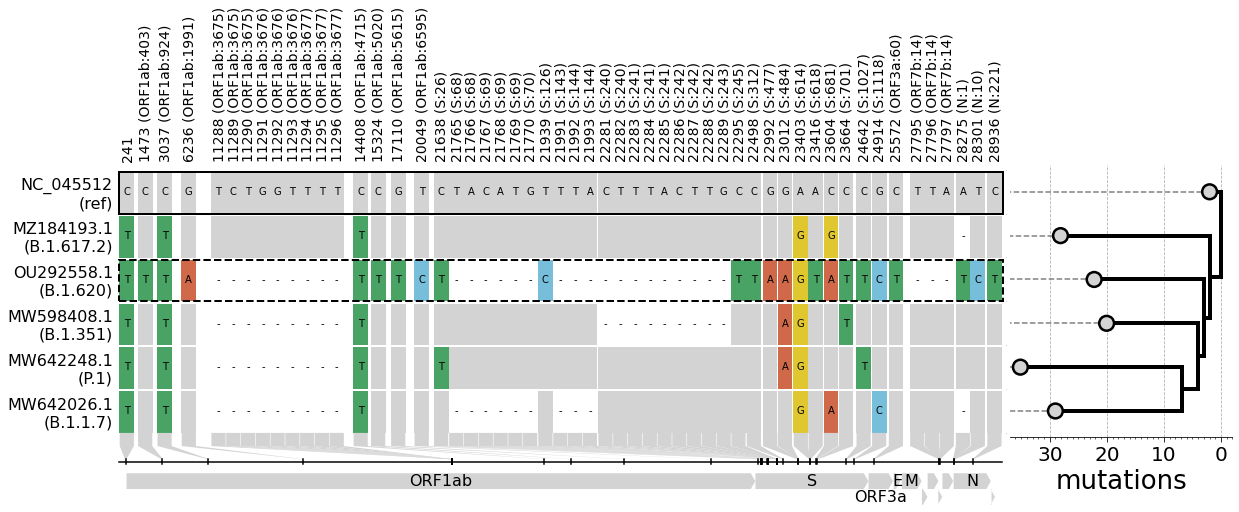

In [2]:
fig = plt.subplots(figsize=(20,5),facecolor='w')

gs = gridspec.GridSpec(1,2,width_ratios=[8,2],hspace=0.01,wspace=0.01)
ax=plt.subplot(gs[0])

colours={'A': '#D0694A', 'C': '#77BEDB', 'T': '#48A365', 'G': '#E1C72F', 
         '-':'w','N':'dimgrey', 
         'K': 'dimgrey', 'Y': 'dimgrey', 'M': 'dimgrey', 'W': 'dimgrey', 'R': 'dimgrey'} ## nucleotide colours

window=3 ## if adjacent SNPs are further apart than this number a tiny horizontal space will be added between nucleotides
ll.sortBranches() ## sort tree
seq_order=[k.name for k in sorted(ll.getExternal(),key=lambda w: w.y)] ## get order of samples from tree

for s,S in enumerate(seq_order): ## iterate over sequences
    cumulative_x=-1 ## begin at x position -1
    store_site=0
    xticks=[] ## 
    
    h=0.95 ## height of nucleotide box
    w=1.0 ## width of nucleotide box
    
    for i,nt in enumerate(SNPs[S]): ## iterate over SNPs of sequence
        fc=colours[seqs[S][nt]] ## get colour for nucleotide box
        
        if store_site+window<nt: ## next site is beyond window, add a tiny space between
            cumulative_x+=1+(nt-store_site)*0.0002
        else:
            cumulative_x+=1 ## SNPs are within window space, no additional horizontal space
        
        if S==ref or SNPs[S][nt]==SNPs[ref][nt]: ## at reference sequence or SNP is same as reference
            fc='lightgrey' if SNPs[S][nt]!='-' else 'none' ## nucleotide box is grey unless gap (in which case white)
            
        rect=Rectangle((cumulative_x,s),w,h,facecolor=fc,edgecolor='none') ## nucleotide box
        ax.add_patch(rect) ## add to plot
        
        if S==ref or SNPs[S][nt]!=SNPs[ref][nt]: ## nucleotide different from reference or is reference
            ax.text(cumulative_x+0.5,s+0.5,seqs[S][nt],size=10,ha='center',va='center') ## add text to nucleotide box
        
        xticks.append(cumulative_x) ## remember tick position
        store_site=nt ## store nucleotide position
        
    if S==ref: ## at reference
        ax.add_patch(Rectangle((0,s),cumulative_x+1.1,h,facecolor='none',edgecolor='k',lw=2)) ## add black outline
        

y_start=min([k.y for k in ll.getExternal() if k.name in focus_sequences]) ## get the lowest y position amongst focal sequences
ax.add_patch(Rectangle((0,y_start-0.5),cumulative_x+1.1,len([k for k in ll.getExternal() if k.name in focus_sequences])-(1-h),facecolor='none',edgecolor='k',lw=2,ls='--',zorder=1000)) ## add rectangle outline around focal set
        
### highlight/mark the position of every SNP in the alignment
for site,nt in zip(xticks,variable): ## iterate over all variable sites
    y=-0.05*len(seq_order) ## y position
    skip=0.05*len(seq_order) ## skip
    tick_size=0.02*len(seq_order) ## tick size marking SNP
    low_y=y-skip ## where the lowest y position is
    f=0.02 ## pad polygon on either side
    point=(nt/alnL)*(cumulative_x+1) ## where the site is located within alignment caricature
    
    ### polygon outline coordinates
    A=(site+f,0)
    B=(site+f,y)
    C=(point-0.05,low_y)
    D=(point+0.05,low_y)
    E=(site+1-f,y)
    F=(site+1-f,0)
    
    ax.add_patch(Polygon([A,B,C,D,E,F],facecolor='lightgrey',edgecolor='none',clip_on=False)) ## add polygon
    ax.plot([point,point],[low_y,low_y-tick_size],color='k',clip_on=False) ## add tick to alignment
    
    
ax.plot([0,cumulative_x+1],[low_y-tick_size/2,low_y-tick_size/2],color='k',clip_on=False) ## add line representing the alignment

for o in sorted(ORFs,key=lambda s: s[0]): ## iterate over ORFs
    b,e=ORFs[o] ## beginning and end of ORF
    
    begin=(b/alnL)*(cumulative_x+1) ## get position in alignment representation
    end=(e/alnL)*(cumulative_x+1)
    offset=0.8 ## offset arrows along the y position
    w=0.06*len(seq_order) ## width of arrow
    
    kwargs={'width': w, 
            'length_includes_head': True, 
            'head_width': w, 
            'head_length': 0.3, 
            'clip_on': False} ## arrow kwargs
    
    if (e-b)<200: ## if ORF is very short - offset by one arrow width
        offset=offset+w
    elif '7' in o or '8' in o or '9' in o:
        pass
    elif '3' in o:
        ax.text(np.mean([begin,end]),y-offset-w,o,size=16,color='k',ha='center',va='center',zorder=1000,clip_on=False) ## add text in the middle of the arrow
    else:
        ax.text(np.mean([begin,end]),y-offset,o,size=16,color='k',ha='center',va='center',zorder=1000,clip_on=False) ## add text in the middle of the arrow
    
    ax.arrow(begin,y-offset,end-begin,0,facecolor='lightgrey',edgecolor='none',**kwargs) ## add text


ax.xaxis.tick_top() ## tick top of matrix
ax.set_xticks([x+0.55 for x in xticks]) ## tick coordinates are roughly in the middle of nucleotide boxes


labels=[] ## label x coordinates
for i in variable: ## iterate over variable sites
    label=None ## assume non-coding region
    for gene in ORFs: ## iterate over ORFs
        start,end=ORFs[gene]
        if start<=i<=end: ## if site is in an ORF
#             print(i,gene,((i-start+1)//3)+1)
            label='%s (%s:%s)'%(i+1,gene,((i-start+1)//3)+1) ## label nucleotide site, gene and aa site
    
    labels.append(label if label else '%s'%(i+1)) ## add label

ax.set_xticklabels(labels,size=14,rotation=90) ## set x labels

ax.set_yticks([y+0.5 for y in range(len(seqs))]) ## set y axis label positions
yticklabels=[]

for y in seq_order: ## iterate over sequences
    rename='%s\n(%s)'%(y,lineage[y]) ## rename each sequence
    yticklabels.append(rename) ## remember new names

ax.set_yticklabels(yticklabels,size=16) ## set new y axis labels
ax.tick_params(size=0) ## no ticks anywhere

ax.set_xlim(min(xticks)-0.2,cumulative_x+1.2) ## set x axis limits
ax.set_ylim(-0.1,len(seqs)+0.1) ## set y axis limits

[ax.spines[loc].set_visible(False) for loc in ax.spines] ## no spines


ax2=plt.subplot(gs[1]) ## tree subplot

ll.plotTree(ax2,width=4) ## plot tree

for k in ll.getExternal(): ## iterate over tips
    ax2.plot([k.height,ll.treeHeight*1.05],[k.y,k.y],ls='--',color='grey',zorder=90)
    
    s=150
    ec='none'
    country=None
    
    strain=k.name
    fc='lightgrey'
    
    ax2.scatter(k.height,k.y,s=s,facecolor=fc,edgecolor=ec,zorder=100) ## mark tip with circle
    ax2.scatter(k.height,k.y,s=s*2,facecolor='k',edgecolor=ec,zorder=99)

ax2.invert_xaxis() ## invert x axis for tree
ax2.plot()

ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10)) ## tick x axis
ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom']] ## no spines

ax2.tick_params(axis='x',size=5,labelsize=20)
ax2.tick_params(axis='y',size=0,labelsize=0)

ax2.set_ylim(-0.1,len(seqs)+0.1)
ax2.set_xlim(ll.treeHeight*1.05,-2)

ax2.grid(axis='x',ls='--')
ax2.set_xlabel('mutations',size=26)

plt.show()